# Relationship between ATV and Transaction number
- Investigated this to see if we could use it estimate ATF in unmatched transactions
- Conclusion, there is a relationship we can model but still need to know the volume of customer to apply weights in order to use to estimate ATF

In [1]:
# install required packages
import pandas as pd
import numpy as np
from utils.database import query_from_file
import datetime
import time
import plotly.express as px
import psutil
from datetime import datetime, timedelta
from utils import style
import matplotlib
path = '/Users/jennamiles/Documents/credentials'

/Users/jennamiles/.pyenv/versions/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
#this is from database.py
#need to update in utils because of directory issue
import os
from psycopg2 import connect
from pandas import read_sql

def query(sql_statement: str, **kwargs):
    with open(f'{path}', 'r') as credentials:
        connection = connect(credentials.read())
        cursor = connection.cursor()

        if len(kwargs) > 0:
            dataframe = read_sql(sql_statement.format(**kwargs), connection)
        else:
            dataframe = read_sql(sql_statement, connection)

        assert len(dataframe) > 0, 'query returned no results'
        return dataframe
    
def query_from_file(sql_file: str, **kwargs):
    with open(sql_file, 'r') as f:
        return query(f.read(), **kwargs)

### Step 1: Bring in the Flux transactions for a retailer over a given time period

In [20]:
sql = 'pure_scaling.sql'

In [21]:
#read in pure data from SQL query:
start = time.time()
df = query_from_file(sql)
end = time.time()
query_time = end-start
print(f"Query took {query_time:.2f} seconds")

Query took 2.98 seconds


In [27]:
df['month'] = df.transaction_date.dt.month

In [324]:
df.sort_values(by = ['customer_id','transaction_date'], inplace = True)

In [325]:
#check date range
start = df.transaction_date.min()
end = df.transaction_date.max()

print(f'start date is {start}')
print(f'end date is {end}')

start date is 2019-06-01 06:55:58+00:00
end date is 2019-12-30 17:30:10+00:00


### Step 2: Per transaction, get the amount and the number of the customer's transaction this was for the given time period

- Careful!! Overall mean ATV will not be the same as the mean of ATV per customer

In [326]:
#get the transaction amounts in £s
amount = df.total_amount/100

In [497]:
#get the transaction number for hte time period for the customer 
df['number']= df.groupby('customer_id').cumcount()+1
number = df['number']

In [509]:
atf_atv = pd.DataFrame({'amount':amount,'transaction_number':number}).groupby('transaction_number').mean().head(20)

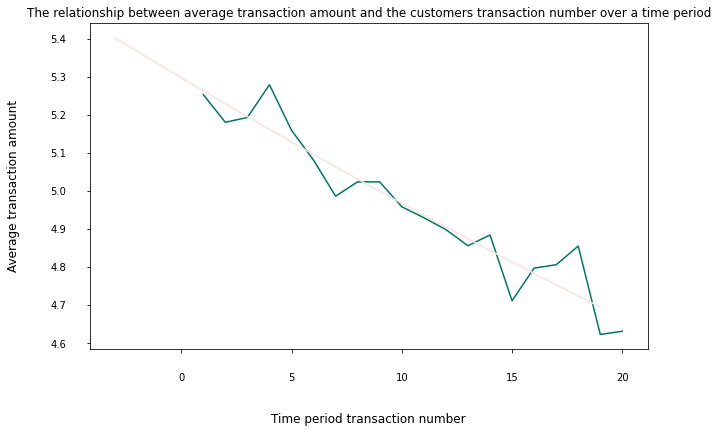

In [527]:
%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(atf_atv)

x = atf_atv.index.values # using the average transaction amount ot predict the average num of transactions
y = atf_atv.amount
p = np.poly1d(np.polyfit(x, y, 2))
plt.plot(np.arange(-3,20), p(np.arange(-3,20)))
plt.xlabel('Time period transaction number', size = 12)
plt.title('The relationship between average transaction amount and the customers transaction number over a time period', size = 12)
_ = plt.ylabel('Average transaction amount', size = 12)

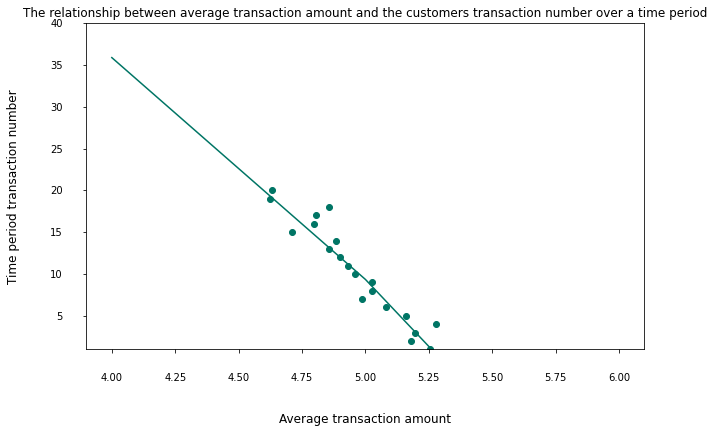

In [585]:
#try to plot the other way around to make it easier to transform 
%matplotlib inline
plt.figure(figsize=(10,6))
plt.scatter(amt, freq)

freq = atf_atv.index.values # using the average transaction amount ot predict the average num of transactions
amt = atf_atv.amount
p = np.poly1d(np.polyfit(amt, freq, 2))
plt.plot(np.arange(4,7), p(np.arange(4,7)))
plt.ylabel('Time period transaction number', size = 12)
plt.title('The relationship between average transaction amount and the customers transaction number over a time period', size = 12)
plt.ylim(1,40)
_ = plt.xlabel('Average transaction amount', size = 12)

- what is the ATV for flux?

In [574]:
flux_atv = df.total_amount.mean()/100
print(flux_atv)

5.067646578888139


- whats the estimated average number of transactions?

In [575]:
est_flux_atn = p(flux_atv)
print(est_flux_atn)

7.356710577240406


### What is this saying?
- The average transaction amount for the entire period is aligned to the average transaction amount spent when customers are on their 7th transaction
- think there is an issue in that it doesn't consider the weight of 1 time transaction customers, 
- E.g. if there were 100 1 time customers with the same transaction value that isn't that different to 2, overall that will make a big difference but on the graph it wont change the shape of the curve, so will pver-predict the ATF, can we use that scaling method???
- or maybe create another plot of ATV (verage amount) by cusotmer volume)?? and then combine somehow


- what's the actual mean number of transactions?

In [576]:
actual_flux_atn = (df.receipt_id.nunique())/(df.customer_id.nunique())
print(actual_flux_atn)

4.161086396628424


- estimates the mean number of transactions per customer pretty well :)
- take a look at the % out it is

In [533]:
pcent_off = (np.sqrt((actual_flux_atn - est_flux_atn)**2)/actual_flux_atn)*100
print(f'The estimate is {pcent_off:.2f}% away from true mean')

The estimate is 23.22% away from true mean


### From all transactions pull in the pure data

In [534]:
#read in pure data from SQL query:
sql2 = 'pure_scaling_all.sql'
start = time.time()
df_all = query_from_file(sql2)
end = time.time()
query_time = end-start
print(f"Query took {query_time:.2f} seconds")

Query took 153.15 seconds


In [535]:
retailter_atv = df_all.amount.mean()
r_atv = retailter_atv/100
r_atv

5.542889156074597

In [536]:
df_all.head()

,transaction_id,adjusted_transaction_date,amount
0,7c45811f-34a8-4ebe-99b4-c2a66ca076e3,2019-10-28 09:21:02+00:00,665
1,7dfd82ec-716f-4c48-a62c-8463a04e3e7c,2019-12-10 17:25:27+00:00,495
2,dd81b692-84e1-47a1-a46b-1fe50ab8ded0,2019-11-18 15:18:23+00:00,1119
3,272a8a01-346f-4c29-bba6-7ebefb47d020,2019-12-16 08:22:54+00:00,299
4,321a35bd-78fa-4cb5-a1b4-dfd404074fae,2019-11-05 10:23:03+00:00,535


In [537]:
est_atn = p(r_atv)
print(est_atn)

5.111587579853538


In [550]:
r_atv/p

array([ 3.87475475e+04, -1.61131159e+02,  1.04624918e+00])

# Thoughts:
- might want to do a test and validate set on the flux data to see how the line performs then 
- might want to try out on a time period that doesnt include when customers first started transacting with a retailer, although on average i think this method should still work
- would maybe need a check in case the line was super flat, just take same ATF as seen in Flux, her price is inelastic to frequency of visit